In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pyproj
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import stats
%matplotlib inline

In [2]:
LL_WGS84 = pyproj.Proj(proj='latlong',datum='WGS84',errcheck=True)
SPCS_N_OR = pyproj.Proj(init = 'nad27:3601')

In [3]:
def convertCoords(x, y):
    '''Converts model coordinaates x, y from spcs to lon/lat'''
    lon_mod, lat_mod = pyproj.transform(SPCS_N_OR, LL_WGS84, x, y)
    return lon_mod, lat_mod

In [4]:
def getMonthSatRegion(filen):
    '''Extracts a particular region of interest from the satellite data.
    Arguments include the filename, min and max longitude, and min and max
    latitude.
    Assumes a monthly dataset, with only one record.
    Longitude inputs should be in range of -155:-105, and latitude inputs
    should be in range of 22:51'''

    fn = nc.Dataset(filen,'r')

    # Read in the variables of interest.
    lon = fn.variables['lon'][:]
    lat = fn.variables['lat'][:]
    MWsstd = fn.variables['MWsstd'][0]

    # Make correction to longitude
    lon = lon - 360.0
    
    # Only interested in part of data that matches with model data. Limits were found above
    idx_lon = np.array(np.where((lon > lonmin) & (lon < lonmax)))
    idx_lat = np.array(np.where((lat > latmin) & (lat < latmax)))
    
    lon_min = idx_lon.min()
    lon_max = idx_lon.max()
    lat_min = idx_lat.min()
    lat_max = idx_lat.max()

    lon_sat = lon[lon_min:lon_max]
    lat_sat = lat[lat_min:lat_max]
    sst_sat = MWsstd[0, lat_min:lat_max, lon_min:lon_max]

    return lon_sat, lat_sat, sst_sat

In [5]:
def readSELFEslab(fn):
    fn = nc.Dataset(fn,'r')
    x = fn.variables['x'][:]
    y = fn.variables['y'][:]
    conn = fn.variables['connectivity'][:]
    temp = fn.variables['water_temperature'][:]
    [lon_mod, lat_mod] = convertCoords(x, y)
    triang = tri.Triangulation(lon_mod, lat_mod, conn)
    
    return lon_mod, lat_mod, temp, triang

In [6]:
def month_avg(data):
    data_m1 = np.ma.masked_array(data,np.isnan(data))
    data_mean = np.mean(data_m1, axis = 1)
    mask = np.ma.getmask(data_mean)
    data_mean[mask] = np.nan
    return data_mean

# This initial attempt generates a runtimeWarning (mean of empty slice). The above is round about, but avoid warning.    
#    data_mean = np.nanmean(data, axis = 1) # This attempt generates a runtimeWarning (mean of empty slice)
#    return data_mean

In [7]:
def interpolateSELFE(triang,data,lon_sat,lat_sat):
    """Interpolates the SELFE data set to the same grid as the satellite data
        grid
    """
    interp = tri.LinearTriInterpolator(triang, data)
    xx,yy = np.meshgrid(lon_sat, lat_sat)
    mod_interp = interp(xx,yy)
    return mod_interp

In [8]:
def load_coast(file_name):
    data = np.loadtxt(file_name)
    coast_x = data[:,0]
    coast_y = data[:,1]
    return coast_x, coast_y

In [9]:
def plume_region(lon, lat, sat_data, mod_data):
    idx_lon = np.array(np.where((lon > -125.2) & (lon < -123.3)))
    idx_lat = np.array(np.where((lat > 45) & (lat < 47)))
    lon_min = idx_lon.min()
    lon_max = idx_lon.max()
    lat_min = idx_lat.min()
    lat_max = idx_lat.max()
    lon_plume = lon[lon_min:lon_max]
    lat_plume = lat[lat_min:lat_max]
    sat = sat_data[lat_min:lat_max, lon_min:lon_max]
    mod = mod_data[lat_min: lat_max, lon_min:lon_max]

    return lon_plume, lat_plume, sat, mod

In [10]:
def plume_edges(data,type):
    ''' Where type is a type of filter for the canny edge
    '''    
    data = data.astype(float)    
    edge_data = type(np.flipud(data))
    return edge_data

In [11]:
def plot_sat_mod(sat, mod, month, tmin, tmax):
    '''The satellite longitude and latitude are constant across the datasets, so there is
    no need to supply the lon/lat for each month. 
    '''
    # Mask part of satellite domain where there are not model data
    sat_m = np.ma.masked_where(np.ma.getmask(mod), sat)
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    p1 = plt.pcolor(lon_sat, lat_sat, sat_m, vmin = tmin, vmax = tmax, cmap = 'Spectral_r')
    plt.colorbar(p1,label='Temperature $^o$C')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Satellite, ' + month + ' 2005')

    plt.subplot(1,2,2)
    p2 = plt.pcolor(lon_sat, lat_sat, mod, vmin = tmin, vmax = tmax, cmap = 'Spectral_r')
    plt.colorbar(p2, label= 'Temperature $^o$C')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('SELFE Model, ' + month + ' 2005')
    plt.tight_layout()    

In [12]:
def plot_sat_mod_plume(sat, mod, month, tmin, tmax):
    '''Plots the plume region off of the Columbia river. ''' 
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    p1 = plt.pcolor(lon_plume, lat_plume, sat, vmin = tmin, vmax = tmax, cmap = 'Spectral_r')
    plt.colorbar(p1,label='Temperature $^o$C')
    plt.plot(coast_x,coast_y,'black')
    plt.xlim(min(lon_plume),max(lon_plume))
    plt.ylim(min(lat_plume),max(lat_plume))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Plume, Satellite, ' + month + ' 2005')

    plt.subplot(1,2,2)
    p2 = plt.pcolor(lon_plume, lat_plume, mod, vmin = tmin, vmax = tmax, cmap = 'Spectral_r')
    plt.colorbar(p2, label= 'Temperature $^o$C')
    plt.plot(coast_x,coast_y,'black')
    plt.xlim(min(lon_plume),max(lon_plume))
    plt.ylim(min(lat_plume),max(lat_plume))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Plume, SELFE Model, ' + month + ' 2005')
    plt.tight_layout()

# Data Files
There are satellite files that represent an average for each month. I also have model data extracted from the surface. The model data are include surface values every 15 minutes for one month of data. Thus, these data require averaging. In addition, to do any model data comparisons, I must interpolate the model data to the satellite grid. 

In [13]:
ls SST_sat_data/

MW2005001_2005031_sstd.nc  MW2005182_2005212_sstd.nc
MW2005032_2005059_sstd.nc  MW2005213_2005243_sstd.nc
MW2005060_2005090_sstd.nc  MW2005244_2005273_sstd.nc
MW2005091_2005120_sstd.nc  MW2005274_2005304_sstd.nc
MW2005121_2005151_sstd.nc  MW2005305_2005334_sstd.nc
MW2005152_2005181_sstd.nc  MW2005335_2005365_sstd.nc


In [14]:
ls SELFE_slabs/

slab_temp_s-1_2005-02-01_2005-03-01.nc  slab_temp_s-1_2005-06-01_2005-07-01.nc
slab_temp_s-1_2005-03-01_2005-04-01.nc  slab_temp_s-1_2005-07-01_2005-08-01.nc
slab_temp_s-1_2005-04-01_2005-05-01.nc  slab_temp_s-1_2005-08-01_2005-09-01.nc
slab_temp_s-1_2005-05-01_2005-06-01.nc


In [15]:
# Read in coastline for model domain. This makes interpretation of plume figures easier. 
[coast_x, coast_y] = load_coast('coastline.dat')

# Data Extraction and Plotting of Figures
Here I am extracting variables from the satellite data and the model data. The satellite data is a monthly average, and the model data includes temperatures for each point at the surface of the domain for an entire month, with a time step of 15 minutes. Thus, this data set will need additional processing before it may be compared with the satellite data.

Before I begin doing further analysis on my model and satellite data, I would like to see what my data look like, and note the general differences between the satellite and model data. These plots allow for an easy visualization across months.

In [16]:
# Model Data
[lon_mod,lat_mod,temp1,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-02-01_2005-03-01.nc')

# Minimum and maximum longitude and latitudes for model domain. Satellite data
lonmin = lon_mod.min()
lonmax = lon_mod.max()
latmin = lat_mod.min()
latmax = lat_mod.max()

# Satellite Data
[lon_sat, lat_sat, sst_Feb] = getMonthSatRegion('SST_sat_data/MW2005032_2005059_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_Feb = month_avg(temp1)
temp_mod_interp_Feb = interpolateSELFE(triang, temp_Feb, lon_sat, lat_sat)

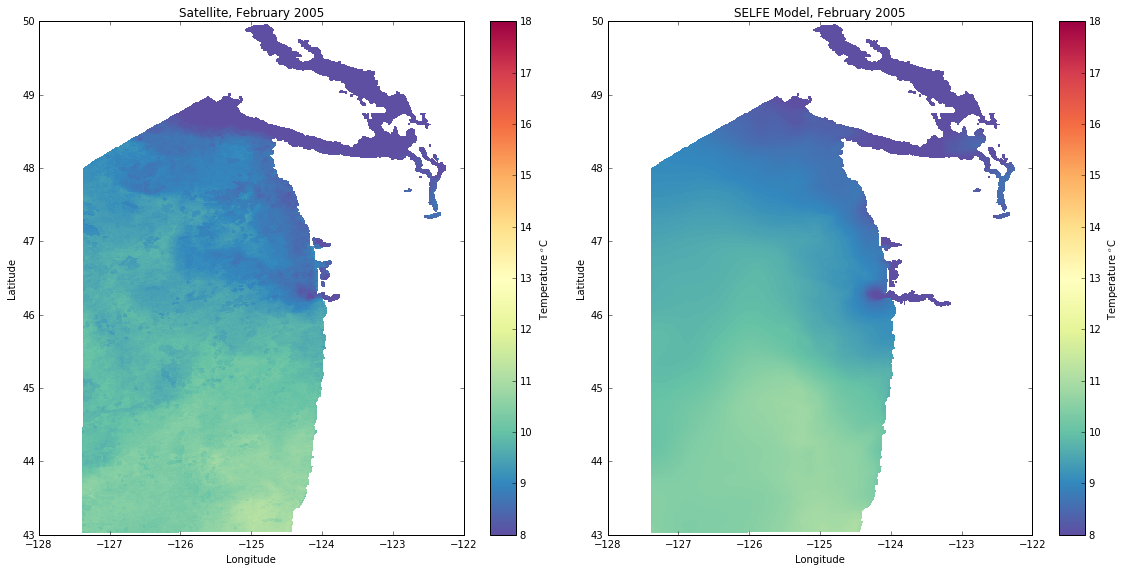

In [17]:
plot_sat_mod(sst_Feb, temp_mod_interp_Feb, 'February', 8, 18)

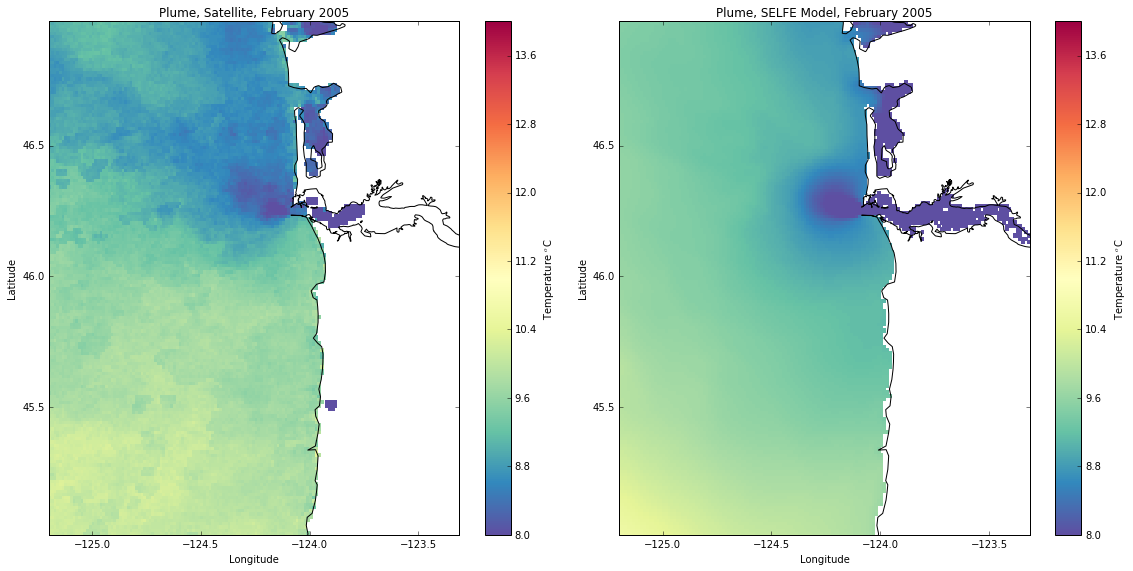

In [18]:
# Extract data for plume region
[lon_plume,lat_plume,sat_p_Feb, mod_p_Feb] = plume_region(lon_sat,lat_sat,sst_Feb, temp_mod_interp_Feb)
# Plot plume region
plot_sat_mod_plume(sat_p_Feb, mod_p_Feb, 'February', 8, 14)

# March 2005

In [19]:
# Model Data
[lon_mod,lat_mod,temp2,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-03-01_2005-04-01.nc')

# Satellite Data
[lon_sat, lat_sat, sst_Mar] = getMonthSatRegion('SST_sat_data/MW2005060_2005090_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_Mar = month_avg(temp2)
temp_mod_interp_Mar = interpolateSELFE(triang, temp_Mar, lon_sat, lat_sat)

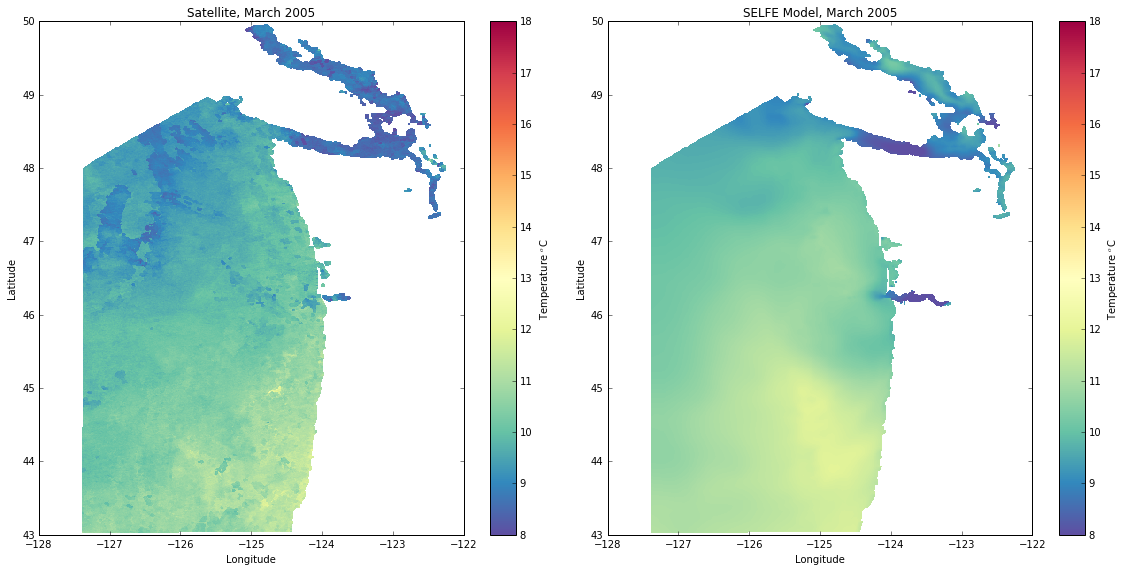

In [20]:
plot_sat_mod(sst_Mar, temp_mod_interp_Mar, 'March', 8, 18)

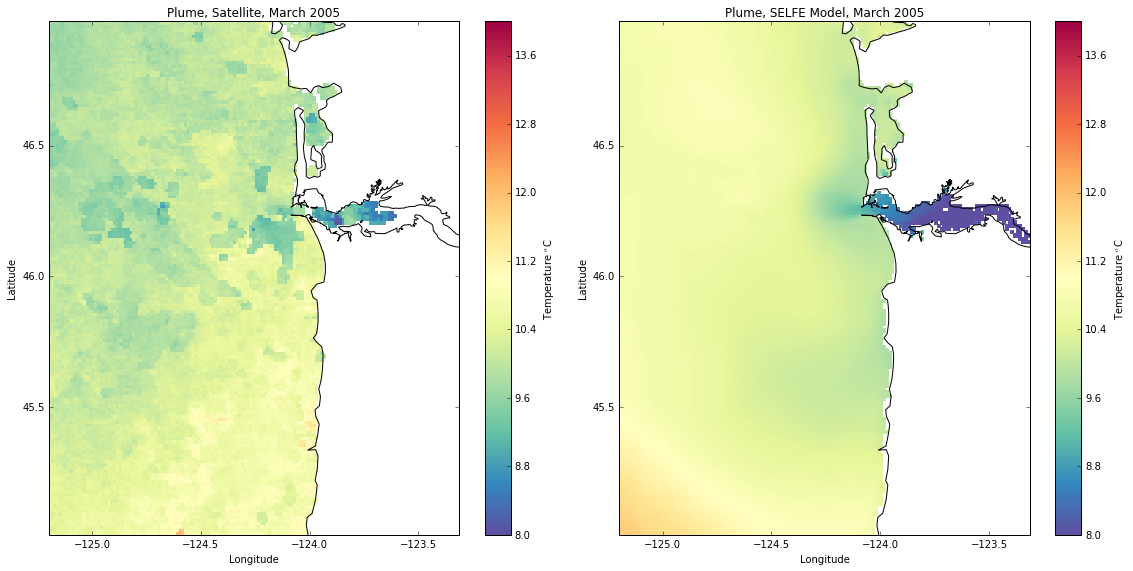

In [21]:
# Extract data for plume region
[lon_p,lat_p,sat_p_Mar, mod_p_Mar] = plume_region(lon_sat,lat_sat,sst_Mar, temp_mod_interp_Mar)
# Plot plume region
plot_sat_mod_plume(sat_p_Mar, mod_p_Mar, 'March', 8, 14)

# April 2005

In [22]:
# Model Data
[lon_mod,lat_mod,temp3,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-04-01_2005-05-01.nc')

# Satellite Data
[lon_sat, lat_sat, sst_Apr] = getMonthSatRegion('SST_sat_data/MW2005091_2005120_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_Apr = month_avg(temp3)
temp_mod_interp_Apr = interpolateSELFE(triang, temp_Apr, lon_sat, lat_sat)

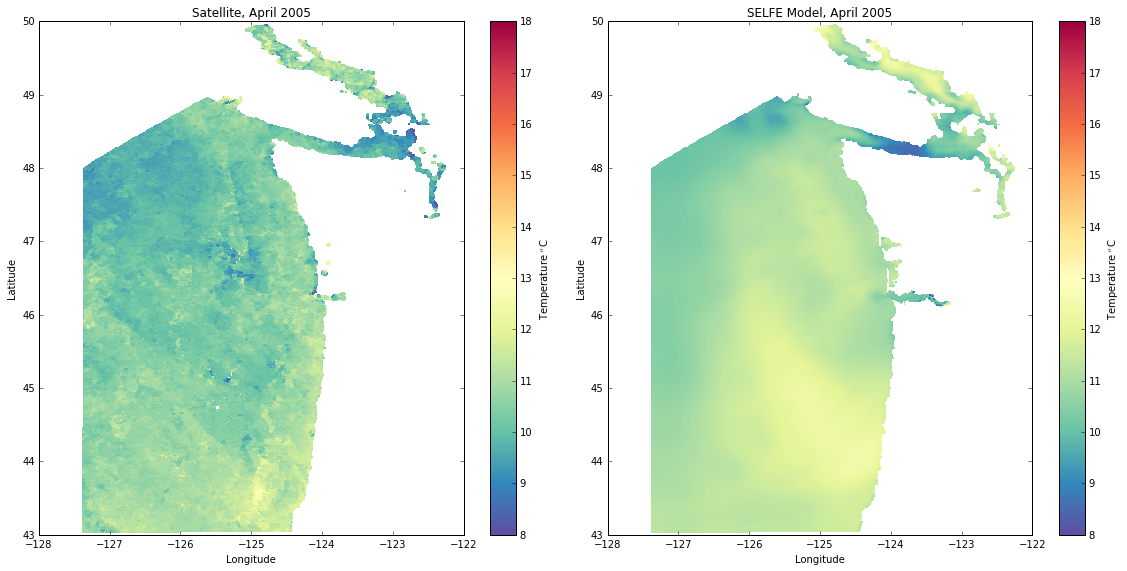

In [23]:
plot_sat_mod(sst_Apr, temp_mod_interp_Apr, 'April', 8, 18)

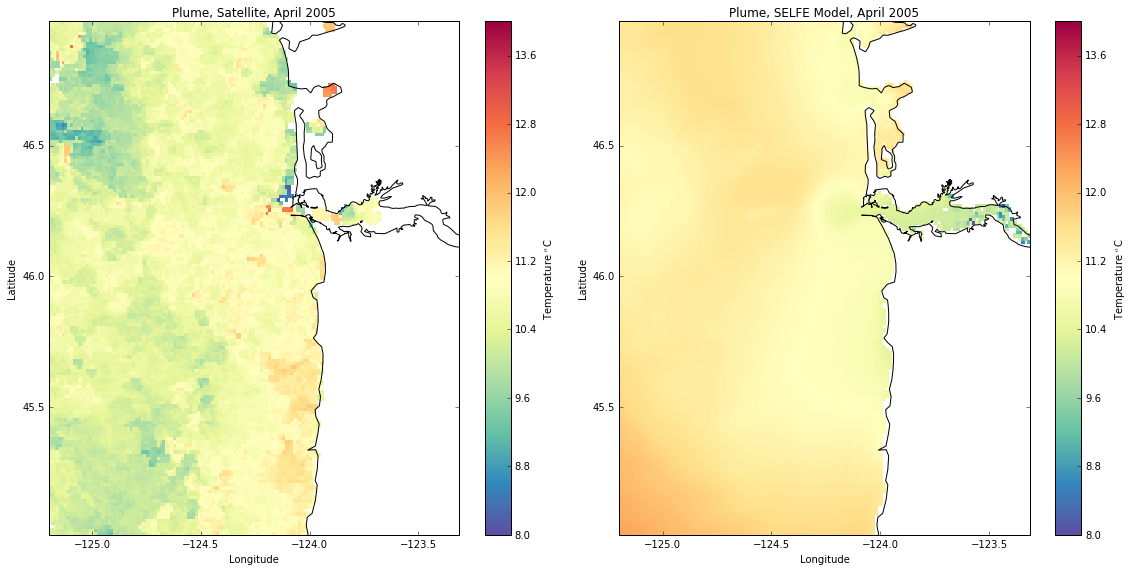

In [24]:
# Extract data for plume region
[lon_p,lat_p,sat_p_Apr, mod_p_Apr] = plume_region(lon_sat,lat_sat,sst_Apr, temp_mod_interp_Apr)
# Plot plume region
plot_sat_mod_plume(sat_p_Apr, mod_p_Apr, 'April', 8, 14)

# May 2005

In [25]:
# Model Data
[lon_mod,lat_mod,temp4,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-05-01_2005-06-01.nc')

# Satellite Data
[lon_sat, lat_sat, sst_May] = getMonthSatRegion('SST_sat_data/MW2005121_2005151_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_May = month_avg(temp4)
temp_mod_interp_May = interpolateSELFE(triang, temp_May, lon_sat, lat_sat)

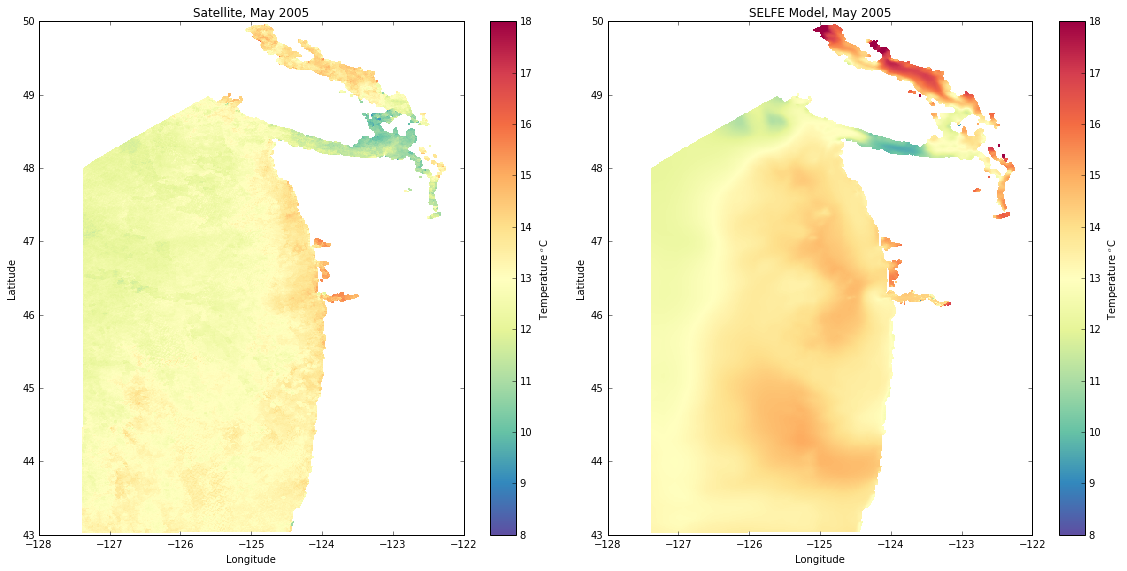

In [26]:
plot_sat_mod(sst_May, temp_mod_interp_May, 'May', 8, 18)

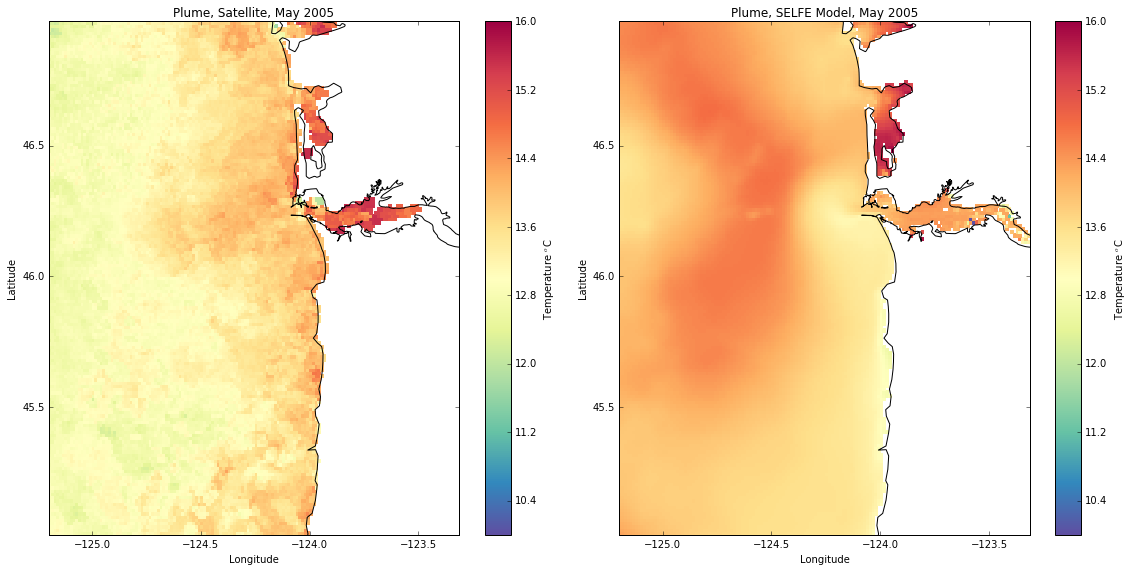

In [27]:
# Extract data for plume region
[lon_p,lat_p,sat_p_May, mod_p_May] = plume_region(lon_sat,lat_sat,sst_May, temp_mod_interp_May)
# Plot plume region
plot_sat_mod_plume(sat_p_May, mod_p_May, 'May', 10, 16)

# June 2005

In [28]:
# Model Data
[lon_mod,lat_mod,temp5,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-06-01_2005-07-01.nc')

# Satellite Data
[lon_sat, lat_sat, sst_June] = getMonthSatRegion('SST_sat_data/MW2005152_2005181_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_June = month_avg(temp5)
temp_mod_interp_June = interpolateSELFE(triang, temp_June, lon_sat, lat_sat)

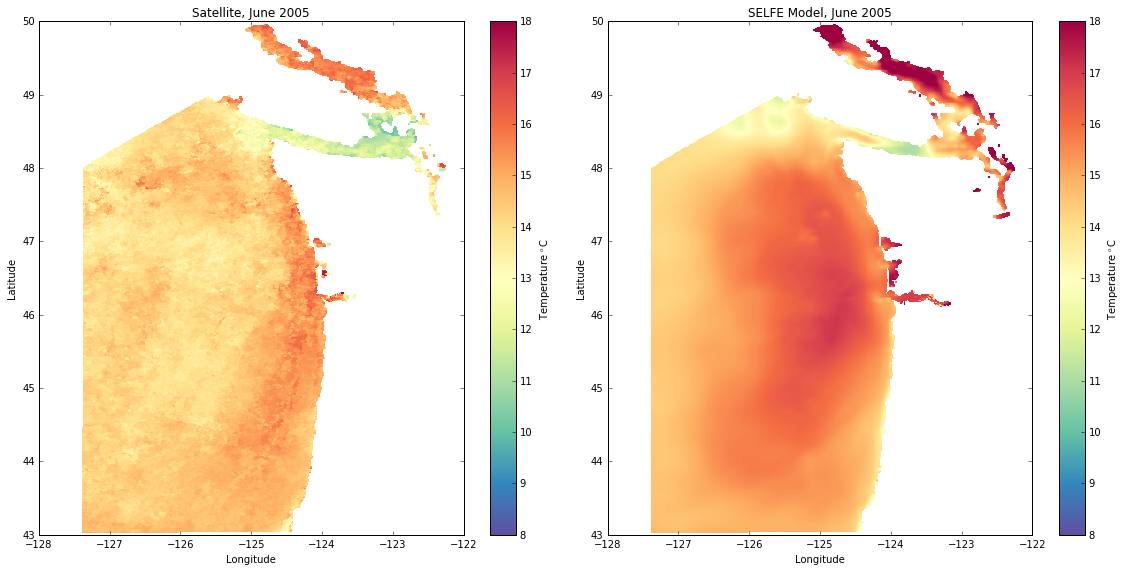

In [29]:
plot_sat_mod(sst_June, temp_mod_interp_June, 'June', 8, 18)

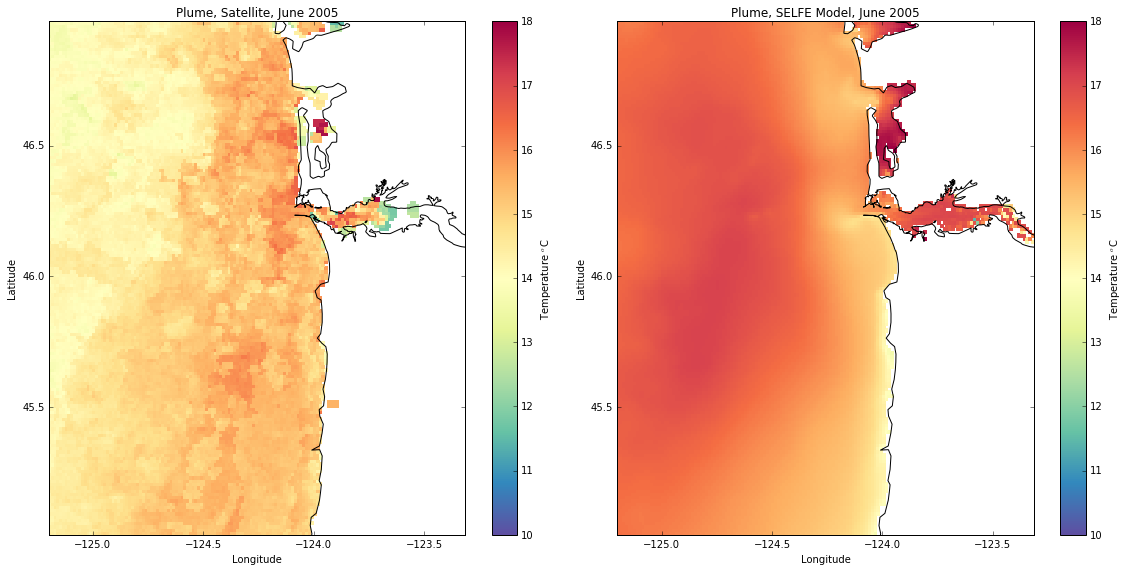

In [30]:
# Extract data for plume region
[lon_p,lat_p,sat_p_June, mod_p_June] = plume_region(lon_sat,lat_sat,sst_June, temp_mod_interp_June)
# Plot plume region
plot_sat_mod_plume(sat_p_June, mod_p_June, 'June', 10, 18)

# July 2005

In [31]:
# Model Data
[lon_mod,lat_mod,temp6,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-07-01_2005-08-01.nc')

# Satelite Data
[lon_sat, lat_sat, sst_July] = getMonthSatRegion('SST_sat_data/MW2005182_2005212_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_July = month_avg(temp6)
temp_mod_interp_July = interpolateSELFE(triang, temp_July, lon_sat, lat_sat)

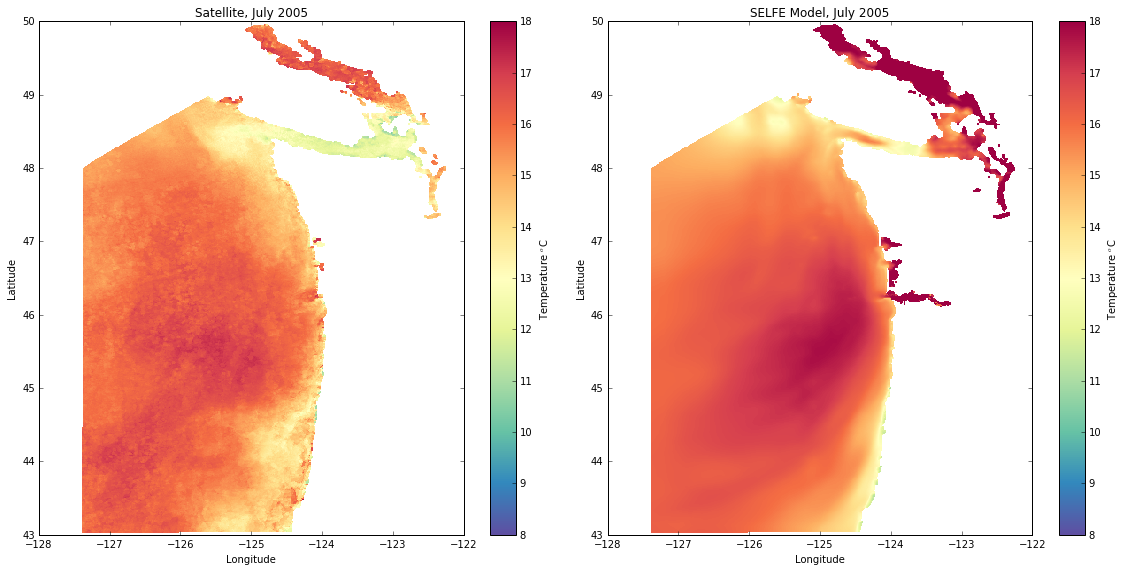

In [32]:
plot_sat_mod(sst_July, temp_mod_interp_July, 'July', 8, 18)

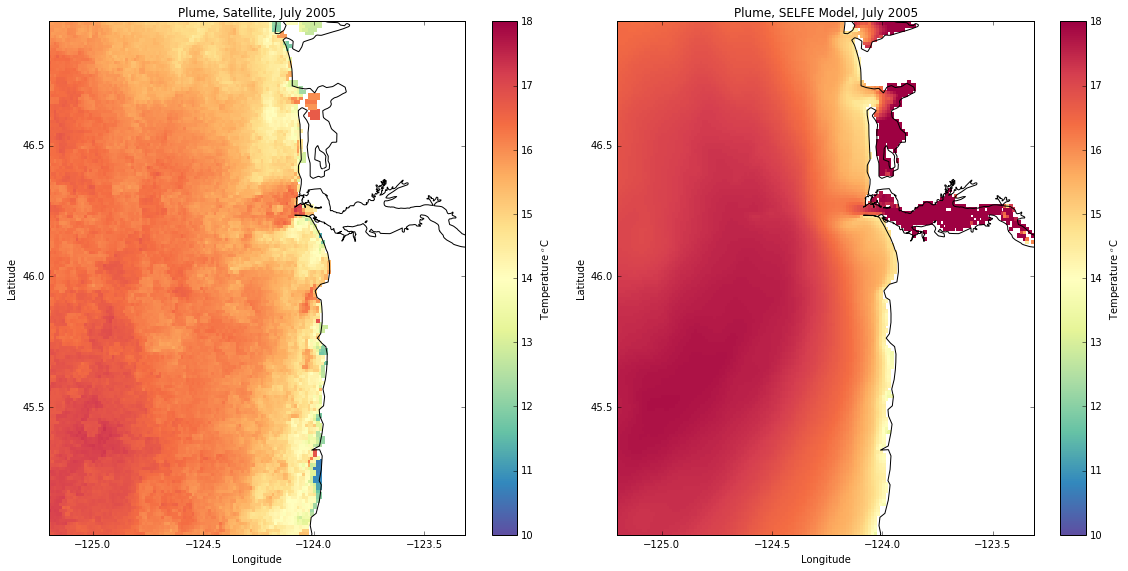

In [33]:
# Extract data for plume region
[lon_p,lat_p,sat_p_July, mod_p_July] = plume_region(lon_sat,lat_sat,sst_July, temp_mod_interp_July)
# Plot plume region
plot_sat_mod_plume(sat_p_July, mod_p_July, 'July', 10, 18)

# August 2005

In [34]:
# Model Data
[lon_mod,lat_mod,temp7,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-08-01_2005-09-01.nc')

# Satelite Data
[lon_sat, lat_sat, sst_Aug] = getMonthSatRegion('SST_sat_data/MW2005213_2005243_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_Aug = month_avg(temp7)
temp_mod_interp_Aug = interpolateSELFE(triang, temp_Aug, lon_sat, lat_sat)

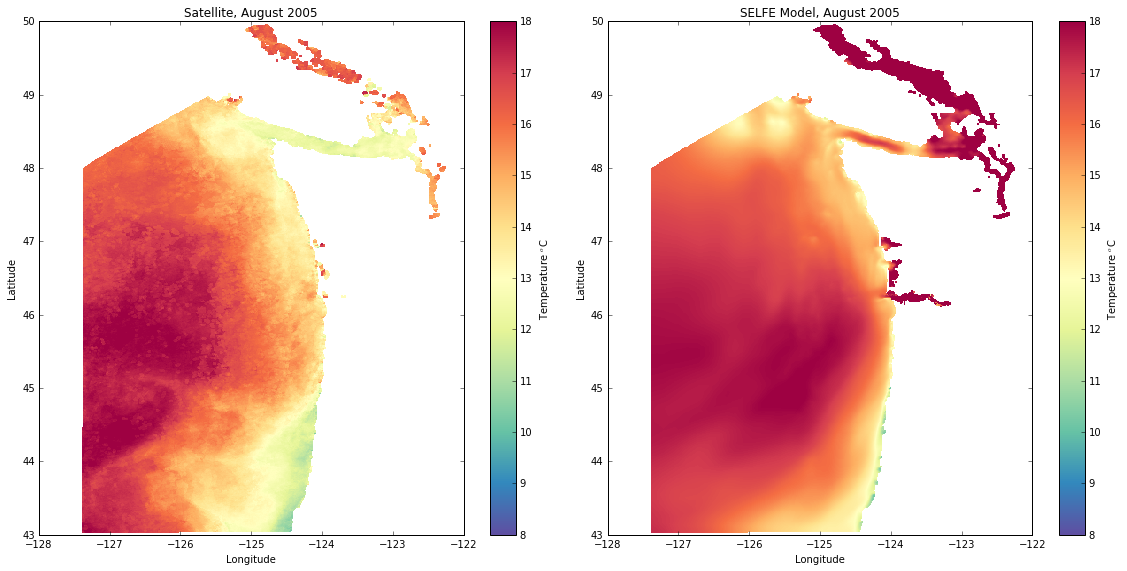

In [35]:
plot_sat_mod(sst_Aug, temp_mod_interp_Aug, 'August', 8, 18)

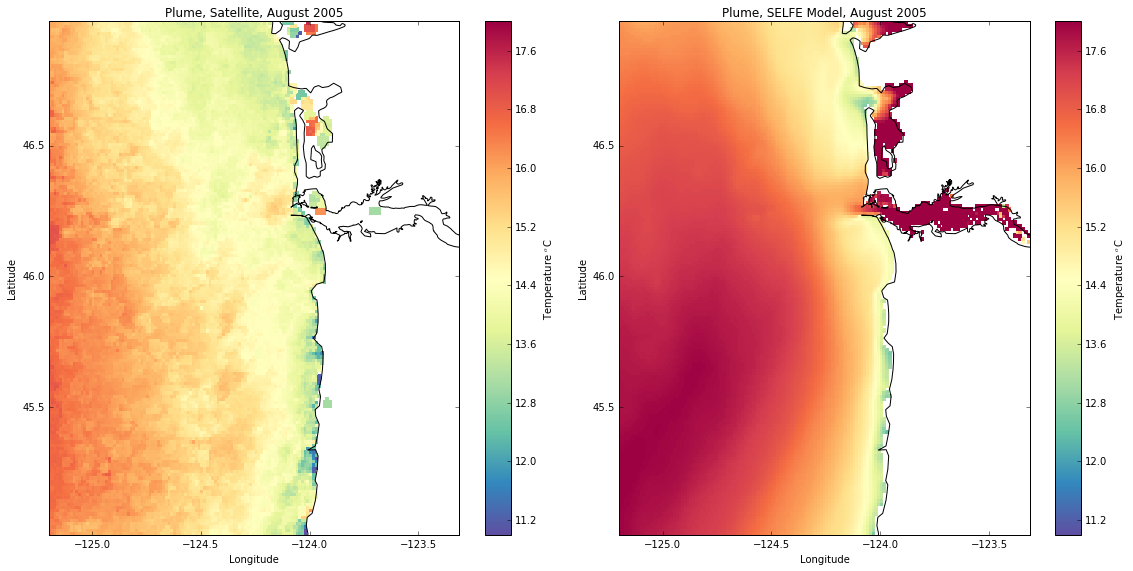

In [36]:
# Extract data for plume region
[lon_p,lat_p,sat_p_Aug, mod_p_Aug] = plume_region(lon_sat,lat_sat,sst_Aug, temp_mod_interp_Aug)
# Plot plume region
plot_sat_mod_plume(sat_p_Aug, mod_p_Aug, 'August', 11, 18)

# Compare the satellite and model data for July

(10, 26)

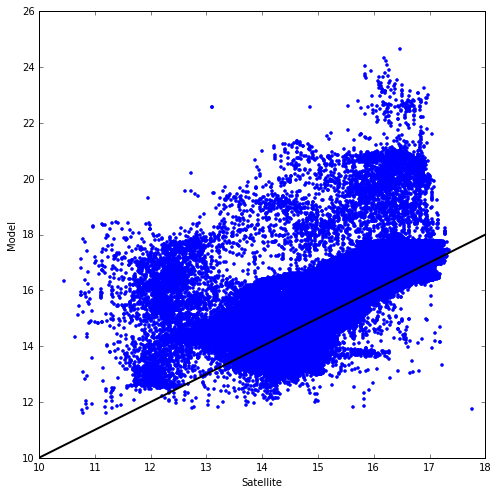

In [37]:
plt.figure(figsize=(8,8))
plt.plot(sst_July,temp_mod_interp_July,'.b')
plt.xlabel('Satellite')
plt.ylabel('Model')
plt.plot([10, 26],[10,26],color='k',linestyle='-',linewidth=2)
plt.xlim(10,18)
plt.ylim(10,26)

# Edge Detection

From the figures above, the plume isn't as obvious as I'd like. I had hoped to work with salinity data, but that data is not highly resolved enough. Thus, I must work with the available data set. The temperature is not ideal to detect the plume, but I will use it anyways, and try to identify a month from above where the plume is more evident. 

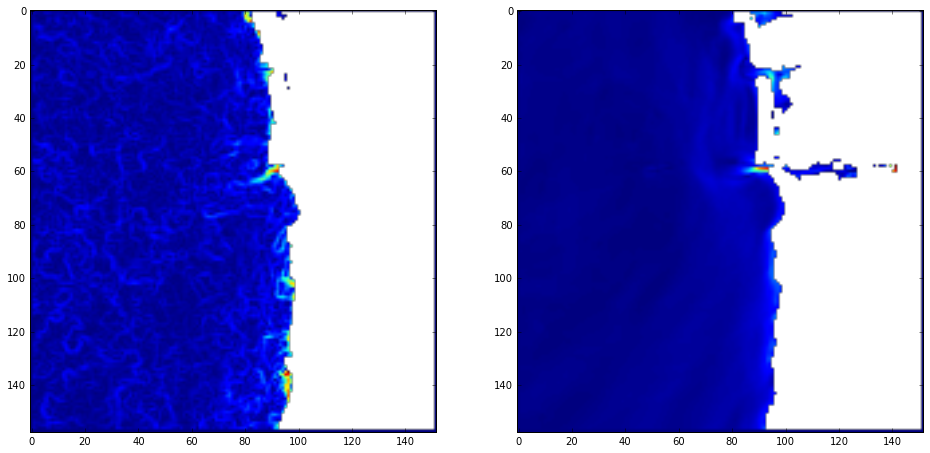

In [38]:
# First need to set empty cells to nan for satellite data
sat_p_July1 = sat_p_July.copy()
sat_p_July1[np.where(sat_p_July.mask == True)] = np.nan
July_edge_sat = plume_edges(sat_p_July1,sobel)
July_edge_mod = plume_edges(mod_p_July,sobel)

plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.imshow(July_edge_sat)

plt.subplot(1,2,2)
plt.imshow(July_edge_mod)

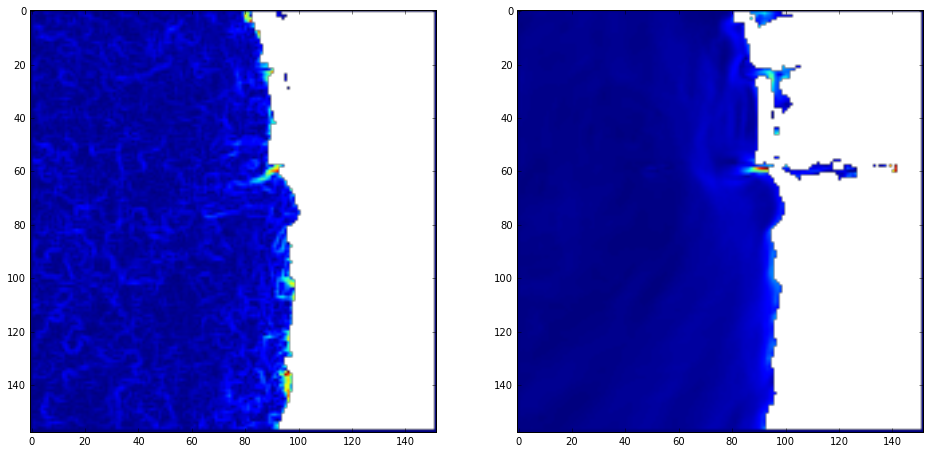

In [39]:
type = prewitt
July_edge_sat = plume_edges(sat_p_July1,type)
July_edge_mod = plume_edges(mod_p_July,type)

plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.imshow(July_edge_sat)

plt.subplot(1,2,2)
plt.imshow(July_edge_mod)


# To-Do
+ Statistics on a the satellite and model data
+ Additional image processing